# DSCI 100 006 Group 32 Project Proposal
### *Relationship Between Housing Prices and House Age*
### Introduction

**Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal**

This dataset contains information about the prices of houses in Sindian Dist., New Taipei City, Taiwan. It includes factors like the age of the house, its proximity to public transportation, the number of convenience stores nearby, and its geographic coordinates. The goal of this dataset is to build a model that can predict the price of a house based on these factors. This can be useful for people looking to buy or sell a house, as well as for real estate agents and companies.

**Clearly state the question you will try to answer with your project**

Using this dataset, we will be examining housing data from Taiwan to find if there are any relationships between the price of the house and other variables such as house age, house location (latitude and longitude), the distance to the nearest MRT station, and the number of convenience stores in walkable distance.

**Identify and describe the dataset that will be used to answer the question**

Our dataset is a historical record of real estate evaluation in the Sindian District of New Taipei City, Taiwan. The dataset is comprised of the observation number, the date that the house was evaluated, the age of the house in years, the distance to the nearest Mass Rapid Transit (MRT) station in meters, the number of convenience stores in walking distance, the latitude and longitude in degrees, and finally the house price per unit area (10000 New Taiwan Dollar per Ping ~ 3.3m²). There are 414 observations in the dataset, taken between August of 2012 and July of 2013.

### Preliminary exploratory data analysis

In [1]:
# importing libraries

library(readxl)
library(repr)
library(readr)
library(ggplot2)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   mas

**1. Demonstrate that the dataset can be read from the web into R**

In [2]:
# file download
house_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
dest_file <- "data/houses.xlsx"
download.file(house_url, dest_file)

# read file
house_data <- read_xlsx("data/houses.xlsx")
house_data

No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
412,2013.25,18.8,390.96960,7,24.97923,121.5399,40.6
413,2013.00,8.1,104.81010,5,24.96674,121.5407,52.5
414,2013.50,6.5,90.45606,9,24.97433,121.5431,63.9


**2. Clean and wrangle your data into a tidy format**

In [3]:
house_data <- house_data |> 
    rename(
        age = "X2 house age",
        station_distance = "X3 distance to the nearest MRT station",
        store_count = "X4 number of convenience stores",
        price_per_unit = "Y house price of unit area"
    ) |>
    select(-c("No", "X1 transaction date", "X5 latitude", "X6 longitude")) |>
    mutate(store_count = store_count)
house_data

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
32.0,84.87882,10,37.9
19.5,306.59470,9,42.2
13.3,561.98450,5,47.3
⋮,⋮,⋮,⋮
18.8,390.96960,7,40.6
8.1,104.81010,5,52.5
6.5,90.45606,9,63.9


In [4]:
# splitting data into training and testing sets.
house_split <- initial_split(house_data, prop = 0.75, strata = price_per_unit)
house_train <- training(house_split)
house_test <- testing(house_split)

**3. Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.**

In [5]:
house_train_mean <- house_train |>
    summarize(across(age:price_per_unit, mean))
house_train_mean

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
17.09513,1102.354,4.035714,38.07045


Our data does not have any missing values, nor does it have any discrepancies in the amount of observations in each class, so here we have printed out the mean of each predictor variable.

**4. Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.**

Some preliminary visualizations we can create are various scatterplots plotting our chosen predictor variables vs. the house price. This will establish some general hints as to whether or not there are strong enough relationships between the variables.

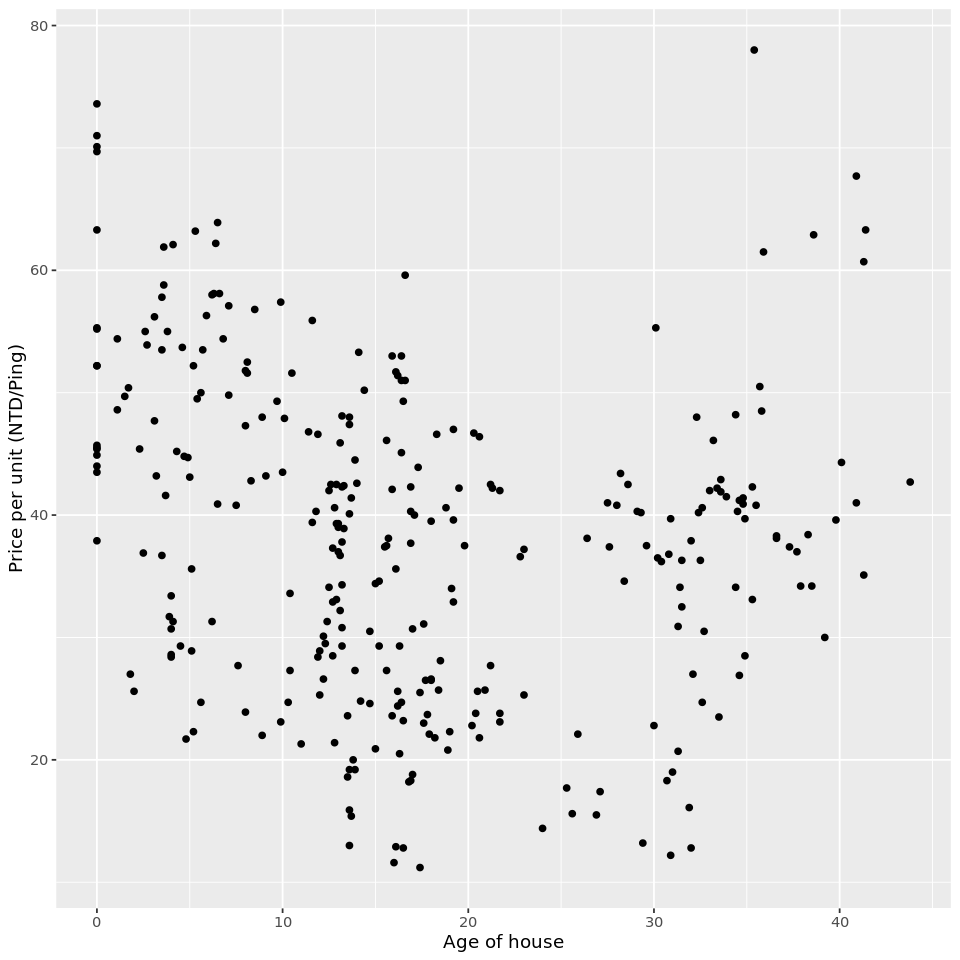

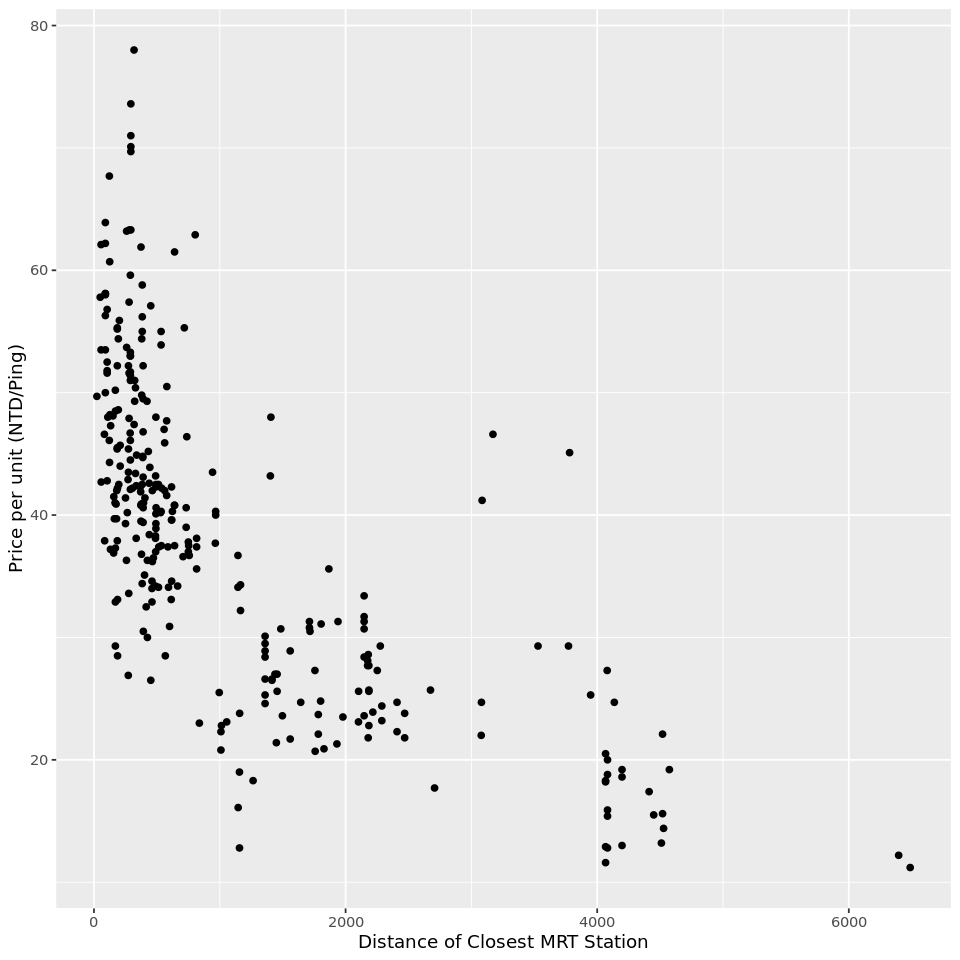

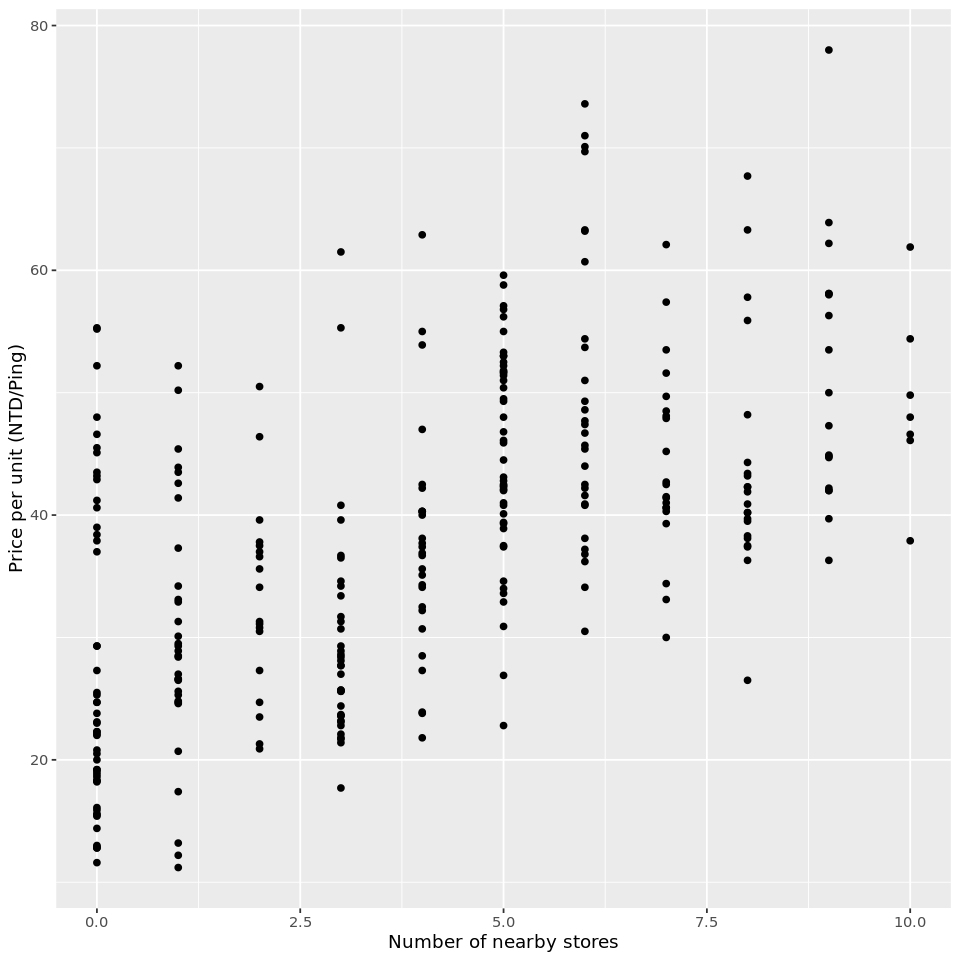

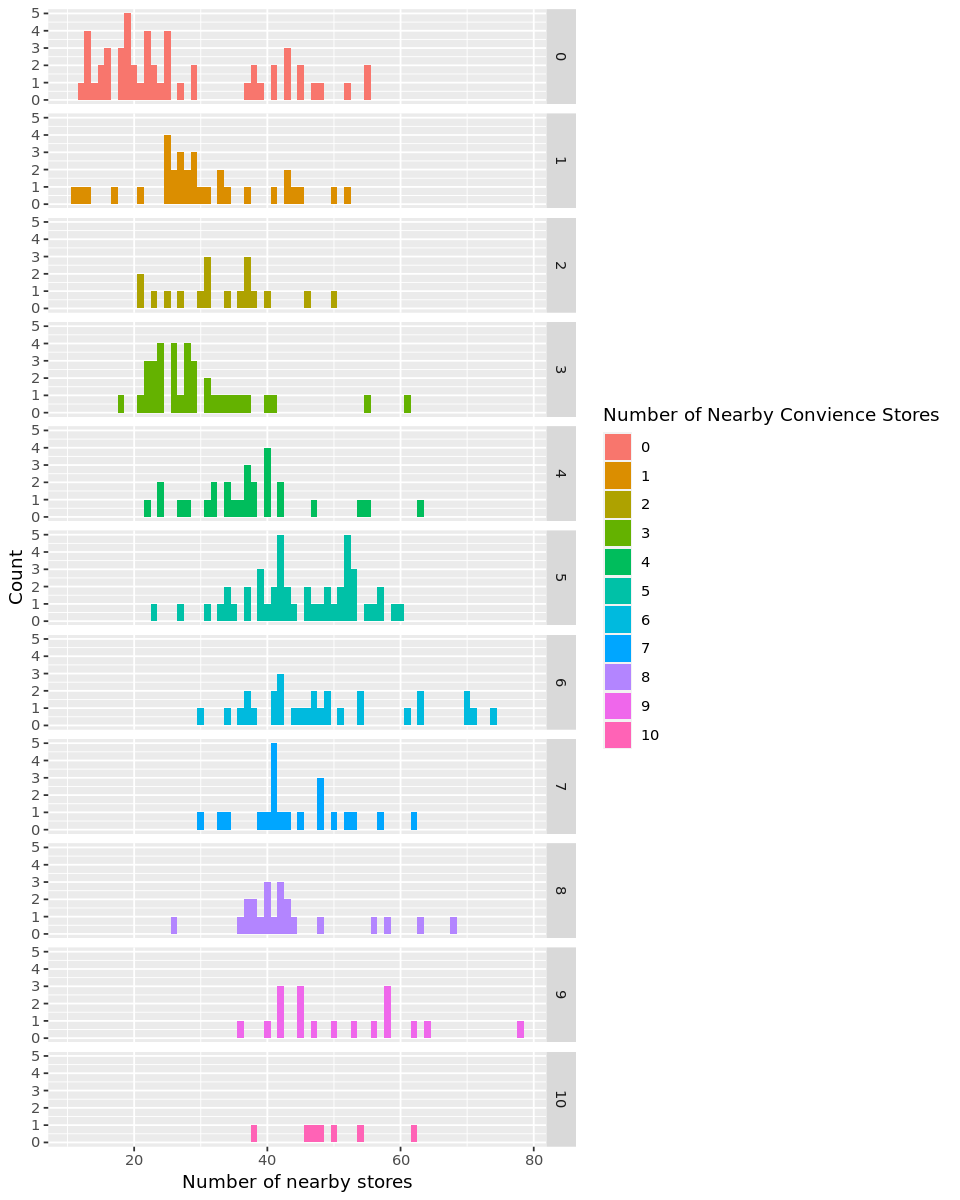

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8)


age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point() +
    labs(x = "Age of house", y = "Price per unit (NTD/Ping)") +
    theme(text = element_text(11))
age_price_plot

station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point() +
    labs(x = "Distance of Closest MRT Station", y = "Price per unit (NTD/Ping)") +
    theme(text = element_text(11))
station_price_plot

store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point() +
    labs(x = "Number of nearby stores", y = "Price per unit (NTD/Ping)") +
    theme(text = element_text(11))
store_price_plot

options(repr.plot.width = 8, repr.plot.height = 10)

store_price_histogram <- house_train |> 
    ggplot(aes(price_per_unit, fill = as_factor(store_count))) +
    geom_histogram(binwidth = 1) +
    facet_grid(rows = vars(store_count)) +
    labs(x = "Number of nearby stores", y = "Count", fill = "Number of Nearby Convience Stores") +
    theme(text = element_text(11))
store_price_histogram

test
